In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pysentimiento import create_analyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm

nltk.download('stopwords')

c:\Users\Lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Utility functions

In [2]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def create_analyzers(lang="en"):
    sentiment_analyzer = create_analyzer(task="sentiment", lang=lang)
    emotion_analyzer = create_analyzer(task="emotion", lang=lang)
    hate_speech_analyzer = create_analyzer(task="hate_speech", lang=lang)

    return sentiment_analyzer, emotion_analyzer, hate_speech_analyzer

def filter_word_cloud(dataframe, stop_words):
    # get all the words in the reviews
    all_words = []

    for text in tqdm(dataframe['review_text']):
        words = word_tokenize(text)
        all_words.extend(words)

    # filter out stop words
    filtered_words = [word for word in all_words if word.lower() not in stop_words]

    # create a word cloud
    generate_wordcloud(' '.join(filtered_words))

### Data analysis

#### Initial analysis

In [3]:
sentiment_analyzer, emotion_analyzer, hate_speech_analyzer = create_analyzers()

In [4]:
# import the clean dataset as a pandas dataframe
CLEAN_DATA_PATH = 'datasets/cleaned_steam_reviews.csv' # change this to the path of the cleaned dataset
df = pd.read_csv(CLEAN_DATA_PATH)

In [5]:
# get the games by review count
games = df['app_name'].value_counts()

# filter out games with less than 1000 reviews
games = games[games > 1000]

# drop all games but these from the original dataframe
reviews = df[df['app_name'].isin(games.index)].copy()
print(reviews.shape)

# split the genres column in the dataframe in a list of genres
reviews['genres'] = reviews['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# split the categories column in the dataframe in a list of categories
reviews['categories'] = reviews['categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# get small substet (5%) of the dataset
reviews = reviews.sample(frac=0.05, random_state=123)
print(reviews.shape)

# get the review texts
review_texts = reviews['review_text']

(3291235, 7)
(164562, 7)


In [6]:
# Sample a text and analyze it
text_sample = review_texts.sample()
sentiment = sentiment_analyzer.predict(text_sample)
emotion = emotion_analyzer.predict(text_sample)
hate_speech = hate_speech_analyzer.predict(text_sample)

print(f"Text: {text_sample}")
print(f"Sentiment: {sentiment}")
print(f"Emotion: {emotion}")
print(f"Hate speech: {hate_speech}")
print()

Map: 100%|██████████| 1/1 [00:00<00:00, 391.77 examples/s]

Text: 2545157    Brilliantly executed and dripping in atmospher...
Name: review_text, dtype: object
Sentiment: [AnalyzerOutput(output=POS, probas={POS: 0.979, NEU: 0.020, NEG: 0.002})]
Emotion: [AnalyzerOutput(output=joy, probas={joy: 0.913, others: 0.077, surprise: 0.005, anger: 0.002, disgust: 0.001, sadness: 0.001, fear: 0.001})]
Hate speech: [AnalyzerOutput(output=[], probas={hateful: 0.015, targeted: 0.011, aggressive: 0.011})]



#### Sentiment analysis

In [7]:
# create the columns for the new data
reviews['sentiment'] = None
reviews['hate_speech'] = None

# for each row in review_texts, predict the sentiment, emotion and hate speech and store in the respective columns
for id, row in tqdm(reviews.iterrows(), desc="Analyzing reviews", total=reviews.shape[0]):
    text = row['review_text']
    sentiment = sentiment_analyzer.predict(text).output
    hate_speech = hate_speech_analyzer.predict(text).output

    # set the values
    reviews.at[id, 'sentiment'] = sentiment
    reviews.at[id, 'hate_speech'] = hate_speech


Analyzing reviews: 100%|██████████| 164562/164562 [5:26:54<00:00,  8.39it/s]  


In [8]:
# sample a review to see new columns
reviews.sample()

,app_id,app_name,review_text,review_score,review_votes,categories,genres,sentiment,hate_speech
1459079,238210,System Shock 2,This is one of my favorite games of all time. ...,1,0,"[Single-player, Multi-player, Co-op, Steam Tra...","[Action, RPG]",POS,[]


In [9]:
COLORS = {
          'green': '#8FBC8F', 
          'red': '#B22222', 
          'blue': '#4682B4'
         }

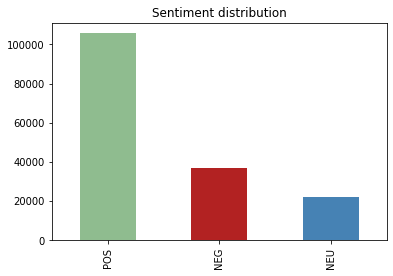

POS    105713
NEG     36784
NEU     22065
Name: sentiment, dtype: int64


In [10]:
# plot proportion of positive, negative and neutral reviews
sentiment_counts = reviews['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red'], COLORS['blue']])
plt.title('Sentiment distribution')
plt.show()

# print the values for each bar
print(sentiment_counts)

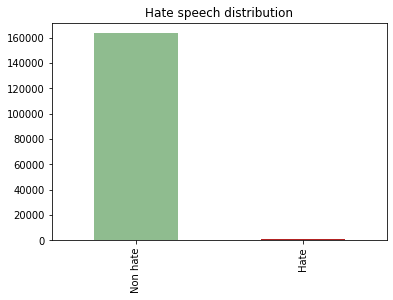

Non hate    163616
Hate           946
Name: hate_speech, dtype: int64


In [11]:
# plot proportion of hate speech and non hate speech reviews
hate_speech_counts = reviews['hate_speech'].apply(lambda x: len(x) > 0).value_counts()
hate_speech_counts.index = ['Non hate', 'Hate']
hate_speech_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red']])
plt.title('Hate speech distribution')
plt.show()

# print the values for each bar
print(hate_speech_counts)

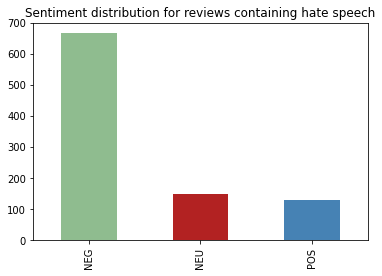

NEG    667
NEU    150
POS    129
Name: sentiment, dtype: int64


In [12]:
hate_speech_reviews = reviews[reviews['hate_speech'].apply(lambda x: len(x) > 0)]

# get the reviews that contain hate speech and plot the sentiment distribution
hate_speech_sentiment_counts = hate_speech_reviews['sentiment'].value_counts()
hate_speech_sentiment_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red'], COLORS['blue']])
plt.title('Sentiment distribution for reviews containing hate speech')
plt.show()

# print the values for each bar
print(hate_speech_sentiment_counts)

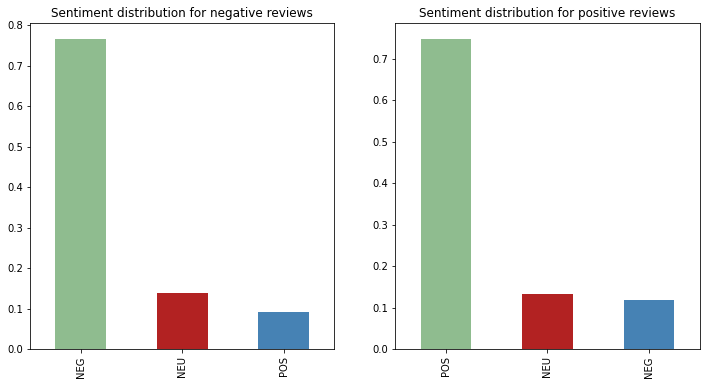

NEG    0.767242
NEU    0.139595
POS    0.093164
Name: sentiment, dtype: float64
POS    0.747767
NEU    0.133026
NEG    0.119207
Name: sentiment, dtype: float64


In [13]:
negative_reviews = reviews[reviews['review_score'] == -1]
positive_reviews = reviews[reviews['review_score'] == 1]

plt.figure(figsize=(12, 6))

# get the reviews that have negative review_score and plot the sentiment distribution for those
plt.subplot(1, 2, 1)
negative_sentiment_counts = negative_reviews['sentiment'].value_counts(normalize=True)
negative_sentiment_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red'], COLORS['blue']])
plt.title('Sentiment distribution for negative reviews')

# get the reviews that have positive review_score and plot the sentiment distribution for those
plt.subplot(1, 2, 2)
positive_sentiment_counts = positive_reviews['sentiment'].value_counts(normalize=True)
positive_sentiment_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red'], COLORS['blue']])
plt.title('Sentiment distribution for positive reviews')

plt.show()

# print the values for each bar
print(negative_sentiment_counts)
print(positive_sentiment_counts)

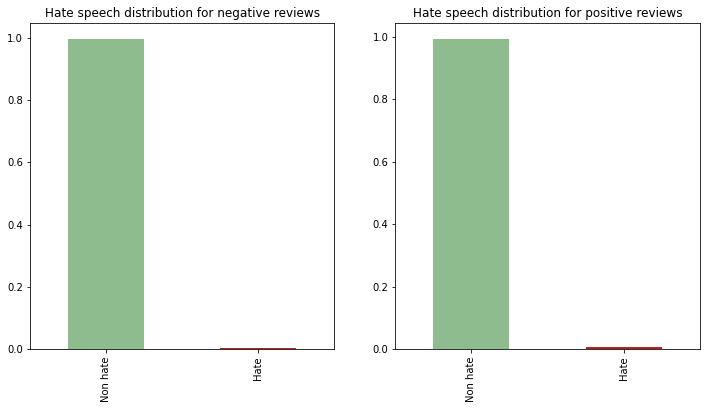

Non hate    0.996301
Hate        0.003699
Name: hate_speech, dtype: float64
Non hate    0.993858
Hate        0.006142
Name: hate_speech, dtype: float64


In [14]:
plt.figure(figsize=(12, 6))

# plot the hate speech distribution for negative reviews
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
negative_hate_speech_counts = negative_reviews['hate_speech'].apply(lambda x: len(x) > 0).value_counts(normalize=True)
negative_hate_speech_counts.index = ['Non hate', 'Hate']
negative_hate_speech_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red']])
plt.title('Hate speech distribution for negative reviews')

# plot the hate speech distribution for positive reviews
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
positive_hate_speech_counts = positive_reviews['hate_speech'].apply(lambda x: len(x) > 0).value_counts(normalize=True)
positive_hate_speech_counts.index = ['Non hate', 'Hate']
positive_hate_speech_counts.plot(kind='bar', color=[COLORS['green'], COLORS['red']])
plt.title('Hate speech distribution for positive reviews')

plt.show()

# print the values for each bar
print(negative_hate_speech_counts)
print(positive_hate_speech_counts)

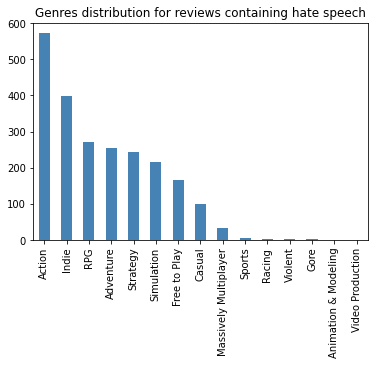

Action                   573
Indie                    398
RPG                      271
Adventure                255
Strategy                 245
Simulation               215
Free to Play             165
Casual                   101
Massively Multiplayer     33
Sports                     5
Racing                     3
Violent                    2
Gore                       2
Animation & Modeling       1
Video Production           1
Name: genres, dtype: int64


In [15]:
# analyze the genres distribution of the reviews with hate speech
hate_speech_genres = hate_speech_reviews['genres'].explode().value_counts()
hate_speech_genres.plot(kind='bar', color=COLORS['blue'])
plt.title('Genres distribution for reviews containing hate speech')
plt.show()

# print the values for each bar
print(hate_speech_genres)

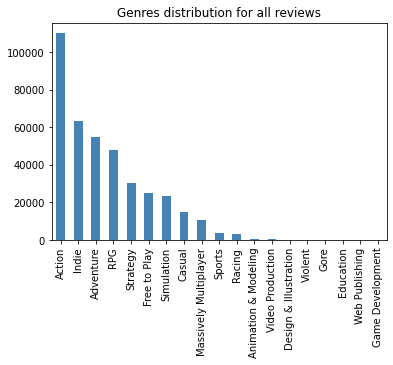

Action                   110227
Indie                     63559
Adventure                 54615
RPG                       48129
Strategy                  30350
Free to Play              25182
Simulation                23440
Casual                    14782
Massively Multiplayer     10603
Sports                     3821
Racing                     3215
Animation & Modeling        421
Video Production            421
Design & Illustration       168
Violent                     157
Gore                        139
Education                   103
Web Publishing              103
Game Development            103
Name: genres, dtype: int64


In [25]:
# analyze the genres distribution of all reviews
genres = reviews['genres'].explode().value_counts()
genres.plot(kind='bar', color=COLORS['blue'])
plt.title('Genres distribution for all reviews')
plt.show()

# print the values for each bar
print(genres)

#### Word analysis

In [16]:
# get the stop words to filter out 
stop_words = set(stopwords.words('english'))

# also filter some common words for this context that are not stop words
words = ['game', 'play', 'playing', 'played', 'games', "n't"]
stop_words.update(words)

100%|██████████| 164562/164562 [00:37<00:00, 4375.06it/s]


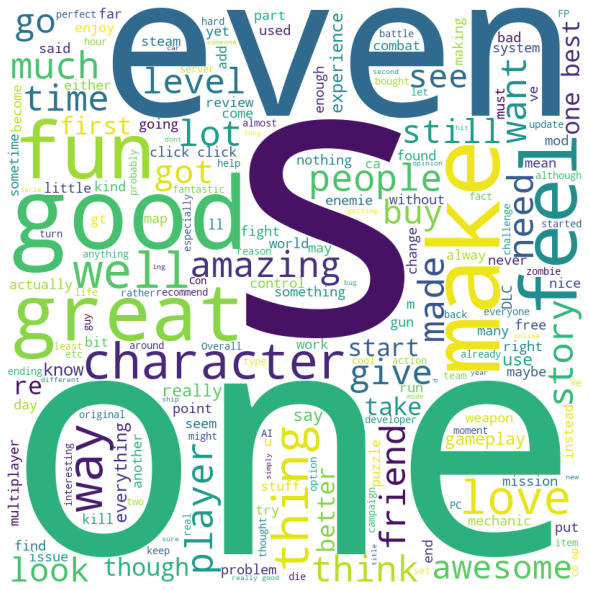

In [17]:
filter_word_cloud(reviews, stop_words)

100%|██████████| 946/946 [00:00<00:00, 5712.22it/s]


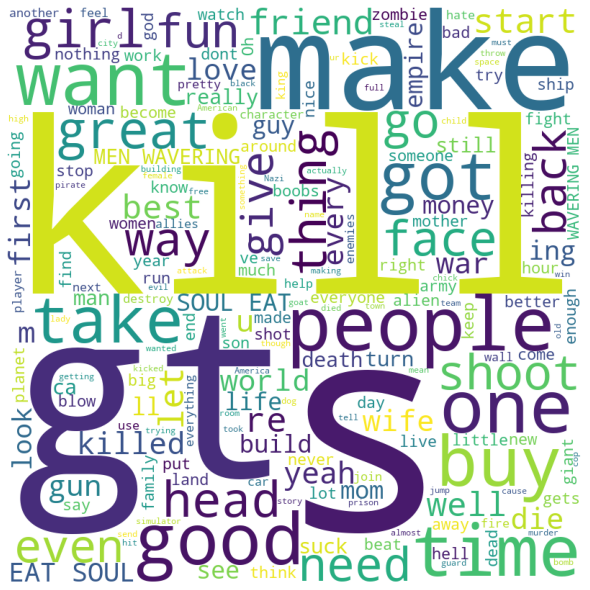

In [18]:
filter_word_cloud(hate_speech_reviews, stop_words)

  0%|          | 0/138071 [00:00<?, ?it/s]

100%|██████████| 138071/138071 [00:29<00:00, 4699.21it/s]


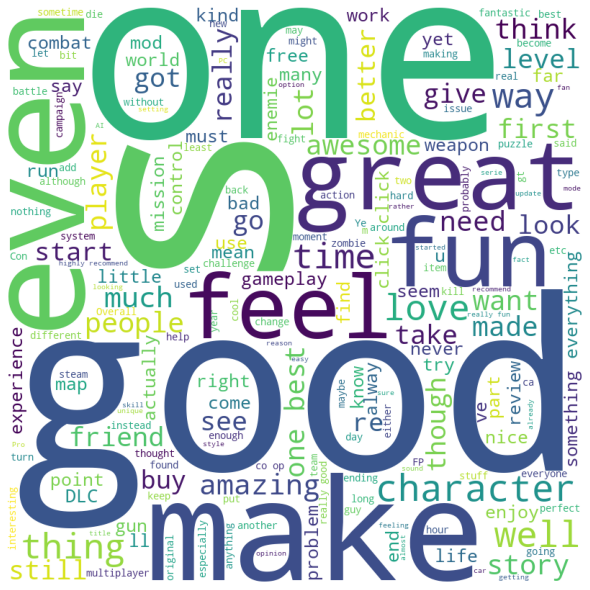

In [19]:
filter_word_cloud(positive_reviews, stop_words)

100%|██████████| 26491/26491 [00:07<00:00, 3396.44it/s]


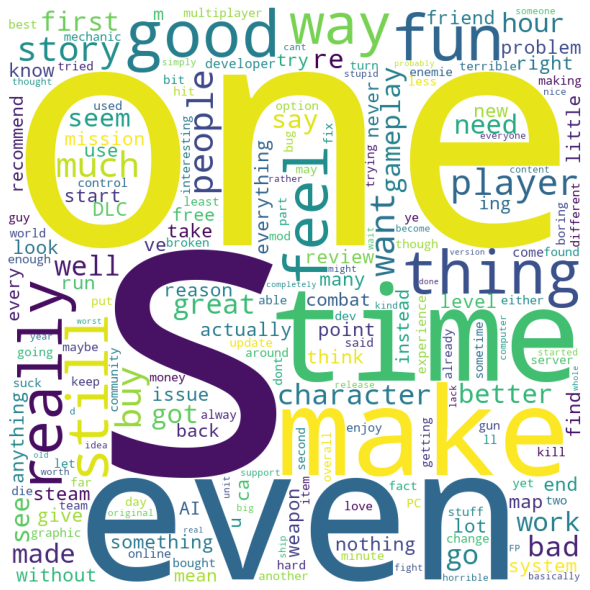

In [20]:
filter_word_cloud(negative_reviews, stop_words)

In [21]:
# show info of review_text of positive reviews that contain hate speech
positive_hate_speech_reviews = positive_reviews[positive_reviews['hate_speech'].apply(lambda x: len(x) > 0)]
print("========================================Hate in positive reviews========================================")

for index, row in positive_hate_speech_reviews.iterrows():
    tokens = word_tokenize(row['review_text'])
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    print(f"App name: {row['app_name']}")
    print(f"Review text: {row['review_text']}")
    print(f"Filtered tokens: {filtered_tokens}")
    print(f"Hate speech: {row['hate_speech']}")
    print()

========================================Hate in positive reviews========================================
App name: Brütal Legend
Review text: the gurls are so hot..
Filtered tokens: ['gurls', 'hot', '..']
Hate speech: ['hateful']

App name: Papers, Please
Review text: Deny foreigners into your glorious nation, strip search suspicious travellers, examine entry permits, shoot terrorists, confiscate passports and watch as your family freezes to death because you spent all your money on rent.   10/10 
Filtered tokens: ['Deny', 'foreigners', 'glorious', 'nation', ',', 'strip', 'search', 'suspicious', 'travellers', ',', 'examine', 'entry', 'permits', ',', 'shoot', 'terrorists', ',', 'confiscate', 'passports', 'watch', 'family', 'freezes', 'death', 'spent', 'money', 'rent', '.', '10/10']
Hate speech: ['hateful', 'aggressive']

App name: Emily is Away
Review text: ****ING BRAD STEALS THE GIRL AGAIN, MOTHER ****ER I WILL ****ING KILL YOU IF I CATCH YOU TALKING TO MY EMILY ABOUT THAT ****** COLD

In [22]:
# show info review_text of negative reviews that contain hate speech
negative_hate_speech_reviews = negative_reviews[negative_reviews['hate_speech'].apply(lambda x: len(x) > 0)]
print("========================================Hate in negative reviews========================================")

for index, row in negative_hate_speech_reviews.iterrows():
    print(f"App name: {row['app_name']}")
    print(f"Review text: {row['review_text']}")
    print(f'Hate speech: {row["hate_speech"]}')
    print()

========================================Hate in negative reviews========================================
App name: Yet Another Zombie Defense
Review text: you ****in suck suck my ****
Hate speech: ['hateful', 'targeted', 'aggressive']

App name: Emily is Away
Review text: The only winning move is not to play in this feminazi narrative, hell-bent on showing and convincing everyone that the male in the relationship is always at fault and that no matter what they say the female is always right. It fools you into thinking you have a choice at first, then you soon learn that none of the choices matter.
Hate speech: ['hateful']

App name: Towns
Review text: Abandonware. DO NOT BUY.
Hate speech: ['hateful']

App name: Heroes & Generals
Review text: **** THIS STUPID ****ING GAME. I HOPE IT BURNS IN HELL. Thank you.
Hate speech: ['hateful', 'aggressive']

App name: Takedown: Red Sabre
Review text: Worst game I've seen in years. I could have taken that 1 Dollar I spent on it and shoved it far do

#### Testing Pysentimiento

In [23]:
# test hate_speech detection in a few phrases
phrases = [
    "I love this game",
    "I hate this game, it's complete garbage",
    "I love this game, it's complete garbage",
    "I hate this game, it's the best",
    "I HATE THIS GAME, IT'S COMPLETE GARBAGE",
    
    "I hate you",
    "I love you",

    "You ****in suck",
    "You ****in rock",
    "You ♥♥♥♥in suck",
    "You ♥♥♥♥in rock",
]

for phrase in phrases:
    hate_speech = hate_speech_analyzer.predict(phrase)
    print(f"Phrase: {phrase}")
    print(f"Hate speech: {hate_speech}")
    print()

Phrase: I love this game
Hate speech: AnalyzerOutput(output=[], probas={hateful: 0.021, targeted: 0.013, aggressive: 0.012})

Phrase: I hate this game, it's complete garbage
Hate speech: AnalyzerOutput(output=[], probas={hateful: 0.033, targeted: 0.016, aggressive: 0.015})

Phrase: I love this game, it's complete garbage
Hate speech: AnalyzerOutput(output=[], probas={hateful: 0.028, targeted: 0.012, aggressive: 0.009})

Phrase: I hate this game, it's the best
Hate speech: AnalyzerOutput(output=[], probas={hateful: 0.025, targeted: 0.011, aggressive: 0.010})

Phrase: I HATE THIS GAME, IT'S COMPLETE GARBAGE
Hate speech: AnalyzerOutput(output=[], probas={hateful: 0.048, targeted: 0.016, aggressive: 0.023})

Phrase: I hate you
Hate speech: AnalyzerOutput(output=['targeted'], probas={hateful: 0.384, targeted: 0.545, aggressive: 0.121})

Phrase: I love you
Hate speech: AnalyzerOutput(output=[], probas={hateful: 0.020, targeted: 0.019, aggressive: 0.012})

Phrase: You ****in suck
Hate speech:

In [24]:
# A review for the game Rogue Legacy and some variations of it
phrase_variations = [
    "I bought this game because i couldn't stop laughing at the way the knights run. so bold, so graceful, so oafish. XD But seriously, one of the greatest rogue games ive ever played. just run into the castle, kill kill kill, get some gold, and DIE! it's that easy! And act now, we'll throw in a dylexic gay dwarf daughter as your heir! XD",
    "I bought this game because i couldn't stop laughing at the way the knights run. so bold, so graceful, so oafish. XD But seriously, one of the greatest rogue games ive ever played. just run into the castle, kill kill kill, get some gold, and DIE! it's that easy! And act now, we'll throw in a dylexic dwarf daughter as your heir! XD",
    "I bought this game because i couldn't stop laughing at the way the knights run. so bold, so graceful, so oafish. XD But seriously, one of the greatest rogue games ive ever played. just run into the castle, kill kill kill, get some gold, and LOSE! it's that easy! And act now, we'll throw in a dylexic dwarf daughter as your heir! XD",
    "I bought this game because i couldn't stop laughing at the way the knights run. so bold, so graceful, so oafish. XD But seriously, one of the greatest rogue games ive ever played. just run into the castle, defeat monsters, get some gold, and LOSE! it's that easy! And act now, we'll throw in a dylexic dwarf daughter as your heir! XD",
    "I bought this game because i couldn't stop laughing at the way the knights run. so bold, so graceful, so oafish. XD But seriously, one of the greatest rogue games ive ever played. just run into the castle, defeat enemies, get some gold, and LOSE! it's that easy! And act now, we'll throw in a dylexic dwarf daughter as your heir! XD",
    "I bought this game because i couldn't stop laughing at the way the knights run. so bold, so graceful, so oafish. XD But seriously, one of the greatest rogue games ive ever played. just run into the castle, get some gold, and LOSE! it's that easy! And act now, we'll throw in a dylexic dwarf daughter as your heir! XD"
]

for phrase in phrase_variations:
    hate_speech = hate_speech_analyzer.predict(phrase)
    print(f"Phrase: {phrase}")
    print(f"Hate speech: {hate_speech}")
    print()

Phrase: I bought this game because i couldn't stop laughing at the way the knights run. so bold, so graceful, so oafish. XD But seriously, one of the greatest rogue games ive ever played. just run into the castle, kill kill kill, get some gold, and DIE! it's that easy! And act now, we'll throw in a dylexic gay dwarf daughter as your heir! XD
Hate speech: AnalyzerOutput(output=['hateful'], probas={hateful: 0.606, targeted: 0.281, aggressive: 0.058})

Phrase: I bought this game because i couldn't stop laughing at the way the knights run. so bold, so graceful, so oafish. XD But seriously, one of the greatest rogue games ive ever played. just run into the castle, kill kill kill, get some gold, and DIE! it's that easy! And act now, we'll throw in a dylexic dwarf daughter as your heir! XD
Hate speech: AnalyzerOutput(output=['hateful'], probas={hateful: 0.591, targeted: 0.262, aggressive: 0.058})

Phrase: I bought this game because i couldn't stop laughing at the way the knights run. so bold,